In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

c:\Users\ishan\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\ishan\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

In [2]:
df = pd.read_csv('MVP_Candidates.csv')
df.fillna(0)

,Unnamed: 0.1,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,0,0,Nikola Jokić,C,5,26,DEN,74,74,10,...,105,117,144,55,230.9,286.9,1,1,0.875,2021-22
1,1,1,Joel Embiid,C,5,27,PHI,68,68,8,...,105,109,243,47,6.5,169.0,0,2,0.706,2021-22
2,2,2,Giannis Antetokounmpo,PF,4,27,MIL,67,67,7,...,93,112,248,49,125.1,211.1,0,3,0.595,2021-22
3,3,3,Devin Booker,SG,2,25,PHO,68,68,1,...,112,102,103,84,-4.1,32.6,0,4,0.216,2021-22
4,4,4,Luka Dončić,PG,1,22,DAL,65,65,5,...,96,101,140,102,-8.9,15.3,0,5,0.146,2021-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,481,481,Bernard King,SF,3,34,WSB,64,64,20,...,103,99,100,30,-38.6,-26.0,0,16,0.007,1990-91
481,482,482,Kenny Smith,PG,1,25,HOU,78,78,8,...,110,112,106,164,115.5,148.1,0,17,0.005,1990-91
482,483,483,Hakeem Olajuwon,C,5,28,HOU,56,50,8,...,101,103,90,5,39.4,31.8,0,18,0.004,1990-91
483,484,484,Tim Hardaway,PG,1,24,GSW,82,82,11,...,105,102,77,198,63.4,44.2,0,19,0.001,1990-91


In [3]:
'''
1990-91 to 1998-99
1999-00 to 2011-12
2012-13 to 2021-22
'''
e1 = ('2021-22', '2020-21', '2019-20', '2018-19', '2017-18', '2016-17', '2015-16', '2014-15', '2013-14', '2012-13')
e2 = ('2011-12', '2010-11', '2009-10' '2008-09', '2007-08', '2006-07', '2005-06', '2004-05', '2003-04', '2002-03', '2001-02', '2000-01')
e3 = ('1999-00', '1998-99', '1997-98', '1996-97', '1995-96', '1994-95', '1993-94', '1992-93', '1991-92', '1990-91')


df1 = df[(df['Year'] == '1999-00') | (df['Year'] == '1998-99') | (df['Year'] == '1997-98') | (df['Year'] == '1996-97') | (df['Year'] == '1995-96') | (df['Year'] == '1994-95') | (df['Year'] == '1993-94') | (df['Year'] == '1992-93') | (df['Year'] == '1991-92') | (df['Year'] == '1990-91')].reset_index(drop=True)


In [4]:
df1

,Unnamed: 0.1,Unnamed: 0,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,310,310,Shaquille O'Neal,C,5,27,LAL,79,79,1,...,70,111,161,0,319.7,223.9,1,1,0.998,1999-00
1,311,311,Kevin Garnett,PF,4,23,MIN,81,81,8,...,102,104,86,32,88.6,75.5,0,2,0.337,1999-00
2,312,312,Alonzo Mourning,C,5,29,MIA,79,78,7,...,95,114,160,2,171.7,212.2,0,3,0.303,1999-00
3,313,313,Karl Malone,PF,4,36,UTA,82,82,4,...,106,111,163,3,94.5,211.6,0,4,0.258,1999-00
4,314,314,Tim Duncan,PF,4,23,SAS,74,74,6,...,101,106,153,5,31.9,99.1,0,5,0.205,1999-00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,481,481,Bernard King,SF,3,34,WSB,64,64,20,...,103,99,100,30,-38.6,-26.0,0,16,0.007,1990-91
172,482,482,Kenny Smith,PG,1,25,HOU,78,78,8,...,110,112,106,164,115.5,148.1,0,17,0.005,1990-91
173,483,483,Hakeem Olajuwon,C,5,28,HOU,56,50,8,...,101,103,90,5,39.4,31.8,0,18,0.004,1990-91
174,484,484,Tim Hardaway,PG,1,24,GSW,82,82,11,...,105,102,77,198,63.4,44.2,0,19,0.001,1990-91


In [5]:
df1.drop(df1.columns[[0, 1]], axis = 1, inplace=True)

In [6]:
#df1['6.3P+'][108] = 0
''' WHY WAS THIS NaN I HAVE NO CLUE - FILLNA SHOULD HAVE MADE IT ZERO '''
''' ANYWAY PROBLEM SOLVED '''

' ANYWAY PROBLEM SOLVED '

In [7]:
df1.to_csv('LessModernEra.csv', index=False)

In [8]:
df1

,Player,Pos,Pos_No,Age,Tm,G,GS,Seed,Win %,1.MP,...,6.FT+,6.TS+,6.FTr+,6.3PAr+,6.FG Add,6.TS Add,MVP,MVP Rank,MVP Share,Year
0,Shaquille O'Neal,C,5,27,LAL,79,79,1,0.817073,3163,...,70,111,161,0,319.7,223.9,1,1,0.998,1999-00
1,Kevin Garnett,PF,4,23,MIN,81,81,8,0.609756,3243,...,102,104,86,32,88.6,75.5,0,2,0.337,1999-00
2,Alonzo Mourning,C,5,29,MIA,79,78,7,0.634146,2748,...,95,114,160,2,171.7,212.2,0,3,0.303,1999-00
3,Karl Malone,PF,4,36,UTA,82,82,4,0.670732,2947,...,106,111,163,3,94.5,211.6,0,4,0.258,1999-00
4,Tim Duncan,PF,4,23,SAS,74,74,6,0.646341,2875,...,101,106,153,5,31.9,99.1,0,5,0.205,1999-00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Bernard King,SF,3,34,WSB,64,64,20,0.365854,2401,...,103,99,100,30,-38.6,-26.0,0,16,0.007,1990-91
172,Kenny Smith,PG,1,25,HOU,78,78,8,0.634146,2699,...,110,112,106,164,115.5,148.1,0,17,0.005,1990-91
173,Hakeem Olajuwon,C,5,28,HOU,56,50,8,0.634146,2062,...,101,103,90,5,39.4,31.8,0,18,0.004,1990-91
174,Tim Hardaway,PG,1,24,GSW,82,82,11,0.536585,3215,...,105,102,77,198,63.4,44.2,0,19,0.001,1990-91


In [9]:
def calc_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2

In [10]:
seasons = ['1999-00', '1998-99', '1997-98', '1996-97', '1995-96', '1994-95', '1993-94', '1992-93', '1991-92', '1990-91']

In [11]:
col_to_drop = []
for i in df1.columns:
    if i[0] == '3' or i[0] == '4':
        col_to_drop.append(i)

In [12]:
season_metrics = {season:[] for season in seasons}
all_results = pd.DataFrame(columns = ['Year', 'Player', 'MVP Share', 'MVP Rank', 'Predicted MVP Share'])

In [13]:
for season in seasons:
    
    testing_data = df1[(df1['Year'] == season)].copy()
    training_data = df1[(df1['Year'] != season)].copy()
    X_train = training_data.drop(['Player', 'Age', 'Pos', 'Pos_No', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
    Y_train = training_data['MVP Share']
    X_test = testing_data.drop(['Player', 'Age', 'Pos', 'Pos_No', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
    Y_test = testing_data['MVP Share']

    X_train.fillna(0)
    X_test.fillna(0)

    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)

    final_params = []

    param_grid = {'alpha':[0.01,0.1,1,5,10,50,100],
                    'l1_ratio':[0.01,0.1,0.5,0.7,0.95,0.99,1]}
    elastic_net_model = ElasticNet()
    grid = GridSearchCV(elastic_net_model, param_grid)
    grid.fit(scaled_X_train, Y_train)
    grid.best_params_
    model = ElasticNet(**grid.best_params_)
    final_params.append(grid.best_params_)

    model.fit(scaled_X_train, Y_train)

    Y_pred = model.predict(scaled_X_test)

    rmse, r2 = calc_metrics(Y_test, Y_pred)

    season_metrics[season] += [rmse, r2]

    initial_results = testing_data[['Year', 'Player', 'MVP Share', 'MVP Rank']]
    results = initial_results.copy()
    results['Predicted MVP Share'] = pd.Series(Y_pred).values
    results = results.sort_values('Predicted MVP Share', ascending=False).reset_index(drop=True)

    print(results)

    all_results = pd.concat([all_results, results])

       Year             Player  MVP Share  MVP Rank  Predicted MVP Share
0   1999-00   Shaquille O'Neal      0.998         1             0.704094
1   1999-00        Karl Malone      0.258         4             0.466828
2   1999-00         Tim Duncan      0.205         5             0.385143
3   1999-00      Kevin Garnett      0.337         2             0.317224
4   1999-00        Gary Payton      0.149         6             0.282734
5   1999-00        Kobe Bryant      0.002        12             0.282335
6   1999-00    Alonzo Mourning      0.303         3             0.220824
7   1999-00       Vince Carter      0.042        10             0.218833
8   1999-00       Chris Webber      0.079         9             0.203929
9   1999-00         Grant Hill      0.093         8             0.194021
10  1999-00      Allen Iverson      0.109         7             0.188030
11  1999-00         Jason Kidd      0.021        11             0.112668
12  1999-00     Michael Finley      0.001        13

In [14]:
for i in season_metrics.keys():
    print(i)
    print("RMSE = ", season_metrics[i][0])
    print("R2 = ", season_metrics[i][1])
    print()

1999-00
RMSE =  0.14748836093975945
R2 =  0.6292091396601651

1998-99
RMSE =  0.22974214475056898
R2 =  -0.015124799361407648

1997-98
RMSE =  0.167249264719497
R2 =  0.5833993586934378

1996-97
RMSE =  0.15273984683975037
R2 =  0.6325947659272133

1995-96
RMSE =  0.1081599483277695
R2 =  0.8091304059049022

1994-95
RMSE =  0.16011523824483334
R2 =  0.5995067592496459

1993-94
RMSE =  0.1690412766734545
R2 =  0.5934389137221129

1992-93
RMSE =  0.18918779993599624
R2 =  0.5646037565858972

1991-92
RMSE =  0.14924233900084222
R2 =  0.639825823687929

1990-91
RMSE =  0.13701985885842485
R2 =  0.6658780670220894



In [15]:
all_test = all_results['MVP Share']
all_pred = all_results['Predicted MVP Share']
total_rmse, total_r2 = calc_metrics(all_test, all_pred)
print("RMSE = ", total_rmse)
print("R2 = ", total_r2)

RMSE =  0.16478196642823528
R2 =  0.5718151513100943


In [16]:
print(all_results.to_string())

       Year             Player MVP Share MVP Rank Predicted MVP Share
0   1999-00   Shaquille O'Neal     0.998        1            0.704094
1   1999-00        Karl Malone     0.258        4            0.466828
2   1999-00         Tim Duncan     0.205        5            0.385143
3   1999-00      Kevin Garnett     0.337        2            0.317224
4   1999-00        Gary Payton     0.149        6            0.282734
5   1999-00        Kobe Bryant     0.002       12            0.282335
6   1999-00    Alonzo Mourning     0.303        3            0.220824
7   1999-00       Vince Carter     0.042       10            0.218833
8   1999-00       Chris Webber     0.079        9            0.203929
9   1999-00         Grant Hill     0.093        8            0.194021
10  1999-00      Allen Iverson     0.109        7             0.18803
11  1999-00         Jason Kidd     0.021       11            0.112668
12  1999-00     Michael Finley     0.001       13             0.01639
13  1999-00      Reg

In [17]:
'''SHAP VARIABLE ANALYSIS - 2021-22 SEASON'''

testing_data = df1[(df1['Year'] == '1997-98')].copy()
training_data = df1[(df1['Year'] != '1997-98')].copy()
X_train = training_data.drop(['Player', 'Age', 'Pos', 'Pos_No', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
Y_train = training_data['MVP Share']
X_test = testing_data.drop(['Player', 'Age', 'Pos', 'Pos_No', 'Tm', 'MVP', 'MVP Rank', 'MVP Share', 'Year'] + col_to_drop, axis=1)
Y_test = testing_data['MVP Share']

X_train.fillna(0)
X_test.fillna(0)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

final_params = []

param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5,10],
                'kernel': ['linear','rbf','poly'],
                'gamma': ['scale','auto'],
                'degree': [2,3,4],
                'epsilon': [0.1,0.5,1]}
svr_model = SVR()
grid = GridSearchCV(svr_model, param_grid)
grid.fit(scaled_X_train, Y_train)
model = SVR(**grid.best_params_)
final_params.append(grid.best_params_)

model.fit(scaled_X_train, Y_train)
#Y_pred = model.predict(scaled_X_test)

explainer = shap.Explainer(model.predict, scaled_X_test)
shap_values = explainer(scaled_X_test)

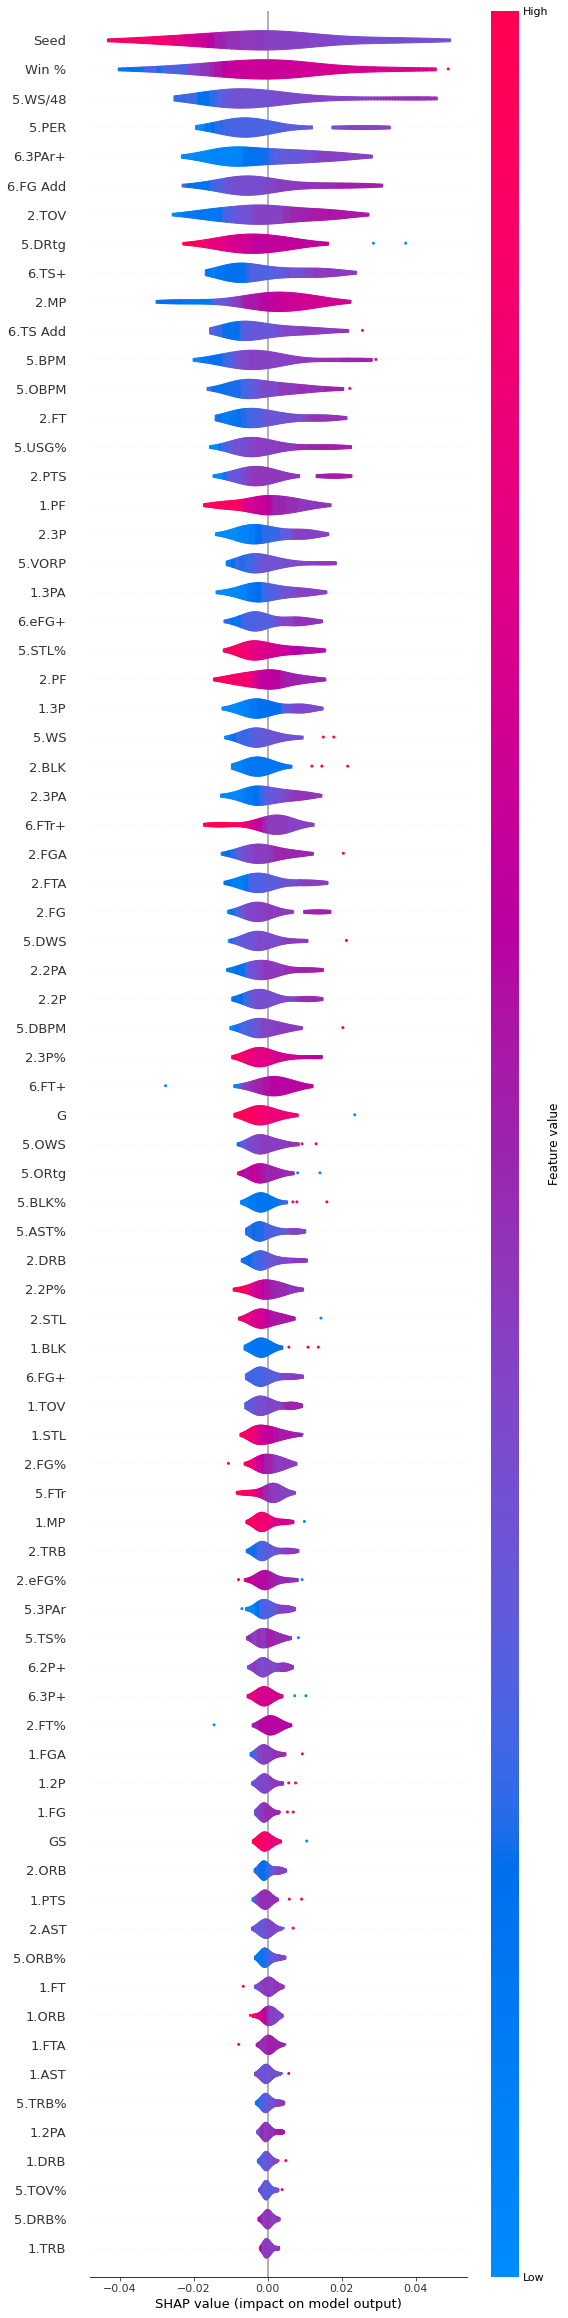

In [18]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns ,plot_type='violin', max_display=len(X_test.columns))

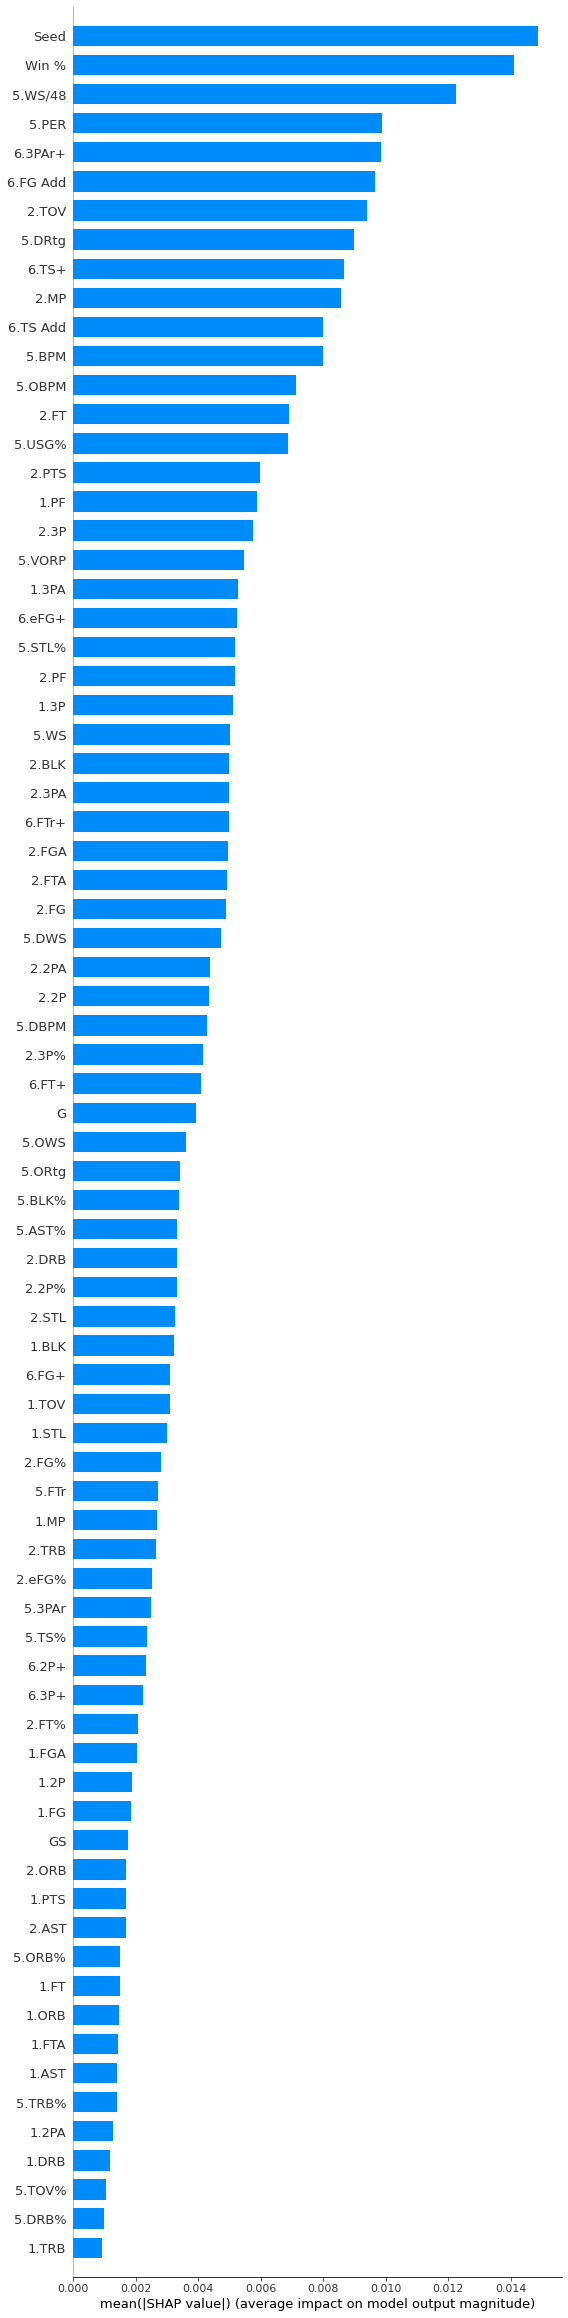

In [19]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns ,plot_type='bar', max_display=len(X_test.columns))